# This notebook builds an ensemble multilabel classifier that combines logistic regression and random forests to make predictions about gene function. 
# The classifiers ability to predict genes in particular functional categories is then visualized using a ROC curve and AUROC analysis

## Imports

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import normalize, label_binarize, LabelEncoder, MultiLabelBinarizer
from sklearn import svm
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import os

%matplotlib inline

In [2]:
lfc_mb_filt=pd.read_csv('../../../data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
lfc_bin_mb_filt=pd.read_csv('../../../data/standardized_data/cleaned_ML/bin_mb_filt.csv')

In [3]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

## Functions

### Function to train LF and RF classifiers and combine predictions 

In [4]:
def rf_lr(mat, cols, C_lr):
    X=mat[cols].values
    y=mat['Functional_Category'].values
    n_classes=mat['Functional_Category'].nunique()
    preds_lr=np.zeros((len(y), n_classes))
    preds_rf=np.zeros((len(y), n_classes))
    #print(X,y)
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train=SMOTE().fit_resample(X_train, y_train)
        lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_lr, random_state=42)
        rf=RandomForestClassifier(n_estimators=100)
        lr.fit(X_train,y_train)
        rf.fit(X_train, y_train)
        preds_lr[test_index,:]=lr.predict_proba(X_test)
        preds_rf[test_index,:]=rf.predict_proba(X_test)
    preds_rf_lr=np.concatenate((preds_lr,preds_rf), axis=1)
    print (preds_rf_lr.shape)
    return preds_rf_lr, y

### Runs log reg on ensemble and generates a confusion matrix

In [5]:
def ensemble_lr(X, y, C, name):
    n_classes=len(np.unique(y))
    confusion=np.zeros((n_classes, n_classes))
    skf=StratifiedKFold(n_splits=2, shuffle=True)
    train_index, test_index=list(skf.split(X,y))[0]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train=SMOTE().fit_resample(X_train, y_train)
    lr=LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C)
    lr.fit(X_train,y_train)
    y_hat=lr.predict(X_test)
    confusion+=confusion_matrix(y_test, y_hat)
    print (classification_report(y_test, y_hat))
    confusion=normalize(confusion, axis=1, norm='l1')
    accuracy=accuracy_score(y_test, y_hat)
    print (accuracy)
    col_names=['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages', 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion=confusion=pd.DataFrame(confusion, columns=col_names, index=col_names)
    #confusion=pd.DataFrame(confusion, columns=clf.classes_, index=clf.classes_)
    plt.figure(figsize=(7,7))
    rc={'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat=sns.heatmap(confusion, annot=True, linewidths=.1, fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)
    fig = heat.get_figure()

    save_dir = '../../../figures'
    os.makedirs(save_dir, exist_ok=True)
    fig_path = os.path.join(save_dir, 'ensemble_preds.png')
    fig.savefig(fig_path, dpi=500, bbox_inches='tight')
    return None

### Evaluation of the classifier metric with AUROC and other precision scoring methods

In [6]:
def ensemble_multilabel(mat, cols, C_lr, norm_method, name, threshold=0.5, n_splits=3, figsize=(7, 7)):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mlb = MultiLabelBinarizer()
    y_multi = mlb.fit_transform([[label] for label in y])
    
    y_true_all = []
    y_pred_all = []
    y_score_all = np.zeros((len(y), n_classes))
    y_score_all = []
    
    with tqdm(total=n_splits, desc="Cross-validation") as pbar:
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_multi[train_index], y_multi[test_index]
            
            if norm_method == 'SMOTE':
                X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            
            lr = LogisticRegression(penalty='l1', solver='liblinear', C=C_lr, random_state=42)
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            
            clf_lr = OneVsRestClassifier(lr)
            clf_rf = OneVsRestClassifier(rf)
            
            clf_lr.fit(X_train, y_train)
            clf_rf.fit(X_train, y_train)
            
            y_score_lr = clf_lr.predict_proba(X_test)
            y_score_rf = clf_rf.predict_proba(X_test)
            
            y_score_combined = (y_score_lr + y_score_rf) / 2
            y_hat_combined = (y_score_combined >= threshold).astype(int)
            
            y_true_all.extend(y_test)
            y_pred_all.extend(y_hat_combined)
            #y_score_all[test_index] = y_score_combined
            y_score_all.extend(y_score_combined)
            
            accuracy.append(accuracy_score(y_test, y_hat_combined))
            pbar.update(1)
    
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_score_all = np.array(y_score_all)
    
    # Per-class metrics
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    print(f"\nPer-class metrics for {name}:")
    for i, class_name in enumerate(col_names):
        precision = precision_score(y_true_all[:, i], y_pred_all[:, i])
        recall = recall_score(y_true_all[:, i], y_pred_all[:, i])
        f1 = f1_score(y_true_all[:, i], y_pred_all[:, i])
        roc_auc = roc_auc_score(y_true_all[:, i], y_score_all[:, i])
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        
        print(f"\nClass {i} - {class_name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-score: {f1:.3f}")
        print(f"  ROC AUC: {roc_auc:.3f}")
    
    # Global metrics (macro average)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    macro_roc_auc = np.mean(roc_aucs)
    
    print(f"\nGlobal Metrics (Macro Average) for {name}:")
    print(f"  Precision: {macro_precision:.3f}")
    print(f"  Recall: {macro_recall:.3f}")
    print(f"  F1-score: {macro_f1:.3f}")
    print(f"  ROC AUC: {macro_roc_auc:.3f}")
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(col_names):
        fpr, tpr, _ = roc_curve(y_true_all[:, i], y_score_all[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_aucs[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize='large')
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    return None


Cross-validation: 100%|██████████████████████████| 5/5 [11:28<00:00, 137.63s/it]



Per-class metrics for Accuracy_log2FC_Ensemble_Multilabel_SMOTE_5fold:

Class 0 - PE/PPE:
  Precision: 0.355
  Recall: 0.309
  F1-score: 0.330
  ROC AUC: 0.830

Class 1 - cell wall and
cell processes:
  Precision: 0.459
  Recall: 0.066
  F1-score: 0.116
  ROC AUC: 0.583

Class 2 - information pathways:
  Precision: 0.212
  Recall: 0.091
  F1-score: 0.127
  ROC AUC: 0.686

Class 3 - insertion seqs
and phages:
  Precision: 0.403
  Recall: 0.408
  F1-score: 0.406
  ROC AUC: 0.835

Class 4 - intermediary metabolism
and respiration:
  Precision: 0.627
  Recall: 0.074
  F1-score: 0.132
  ROC AUC: 0.586

Class 5 - lipid metabolism:
  Precision: 0.357
  Recall: 0.093
  F1-score: 0.147
  ROC AUC: 0.586

Class 6 - regulatory proteins:
  Precision: 0.115
  Recall: 0.051
  F1-score: 0.070
  ROC AUC: 0.617

Class 7 - virulence, detoxification,
adaptation:
  Precision: 0.190
  Recall: 0.086
  F1-score: 0.119
  ROC AUC: 0.656

Global Metrics (Macro Average) for Accuracy_log2FC_Ensemble_Multilabel_SM

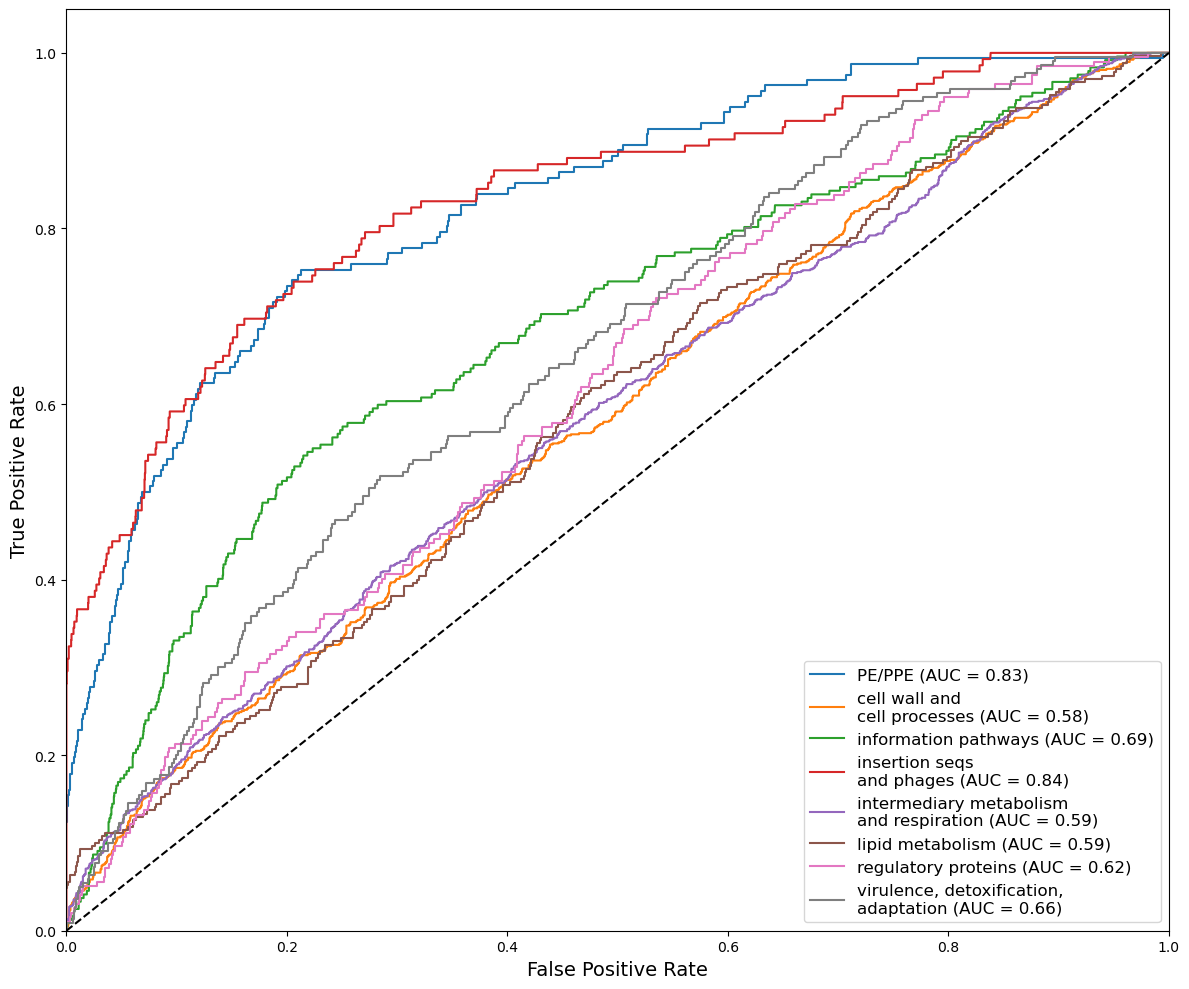

In [7]:
# Ensure the DataFrame and columns are correctly loaded
lfc_mb_filt = pd.read_csv('../../../data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

# Test with 5-fold cross-validation)
ensemble_multilabel(lfc_mb_filt, value_cols, C_lr=10, norm_method='SMOTE', name='Accuracy_log2FC_Ensemble_Multilabel_SMOTE_5fold', n_splits=5)


In [8]:
X_ensemble,y_ensemble=rf_lr(lfc_bin_mb_filt, value_cols_lfc_bin, C_lr=10)

(2937, 16)


In [9]:
X_ensemble[0,:]

array([0.16380355, 0.10052414, 0.13909521, 0.13369088, 0.10146544,
       0.11111001, 0.12047872, 0.12983205, 0.1674054 , 0.09562993,
       0.14159407, 0.13758378, 0.10072307, 0.10518539, 0.11887788,
       0.1330005 ])

                                         precision    recall  f1-score   support

                                 PE/PPE       0.07      0.70      0.13        81
           cell wall and cell processes       0.37      0.08      0.12       386
                   information pathways       0.04      0.01      0.01       121
              insertion seqs and phages       0.20      0.18      0.19        71
intermediary metabolism and respiration       0.36      0.08      0.12       466
                       lipid metabolism       0.12      0.11      0.12       135
                    regulatory proteins       0.05      0.07      0.06        99
  virulence, detoxification, adaptation       0.05      0.07      0.06       110

                               accuracy                           0.11      1469
                              macro avg       0.16      0.16      0.10      1469
                           weighted avg       0.25      0.11      0.11      1469

0.1123213070115725


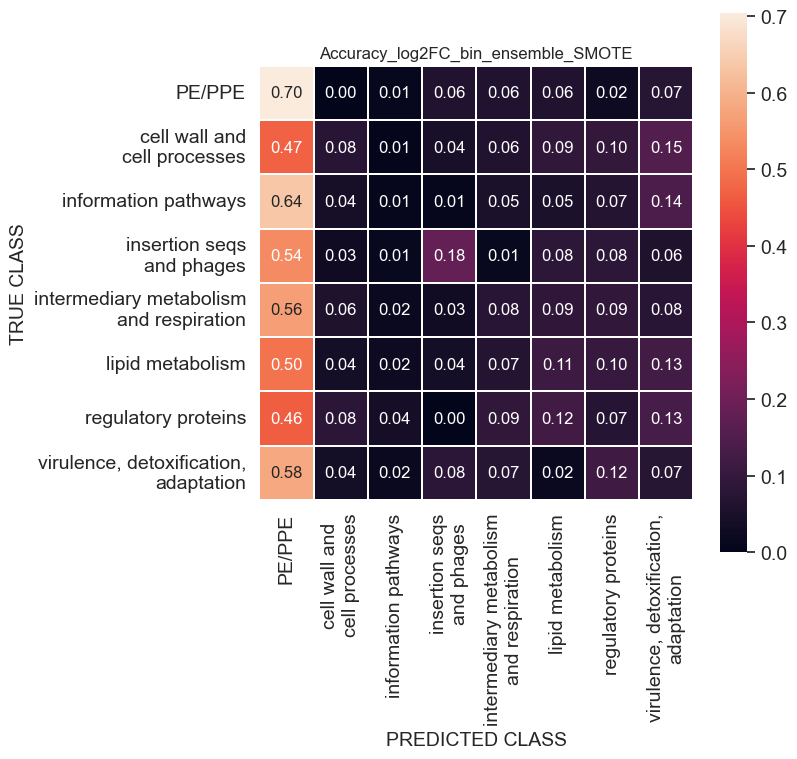

In [12]:
ensemble_lr(X_ensemble, y_ensemble, C=10, name='Accuracy_log2FC_bin_ensemble_SMOTE')

                                         precision    recall  f1-score   support

                                 PE/PPE       0.07      0.74      0.13        81
           cell wall and cell processes       0.38      0.17      0.24       386
                   information pathways       0.06      0.02      0.04       121
              insertion seqs and phages       0.15      0.10      0.12        71
intermediary metabolism and respiration       0.46      0.11      0.18       466
                       lipid metabolism       0.21      0.19      0.20       135
                    regulatory proteins       0.09      0.10      0.10        99
  virulence, detoxification, adaptation       0.05      0.03      0.04       110

                               accuracy                           0.15      1469
                              macro avg       0.19      0.18      0.13      1469
                           weighted avg       0.29      0.15      0.16      1469

0.1531654186521443


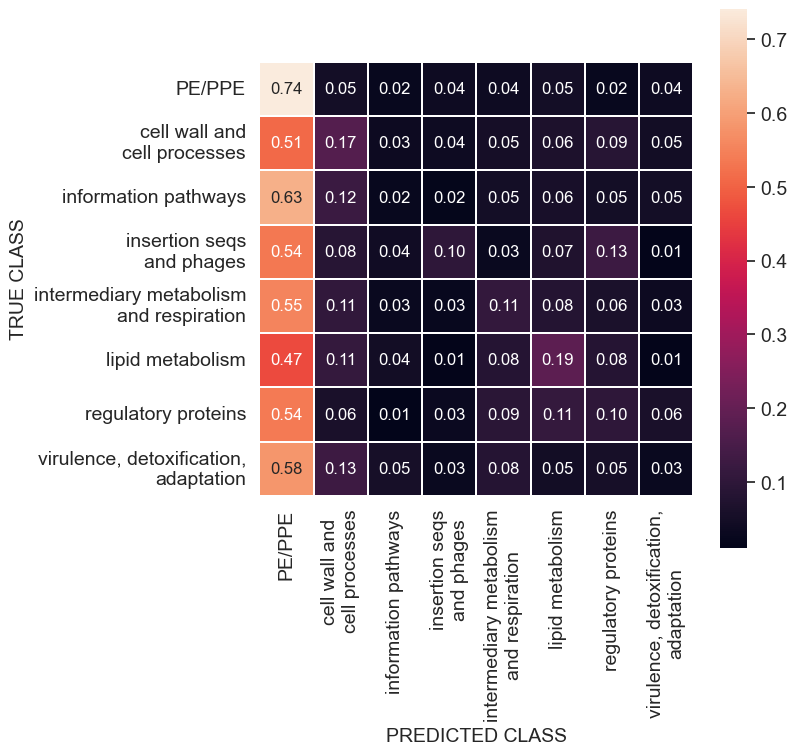

In [13]:
#without title
ensemble_lr(X_ensemble, y_ensemble, C=10, name='')